In [8]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GOOGLE_API_KEY")
_set_env("HF_TOKEN")

In [9]:
from langchain.chat_models import init_chat_model
llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai")

In [10]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

In [11]:
class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str  = Field(
        description="Role of the analyst.",
    )
    description: str = Field(
        description="Description of the analyst focus, concern, and motives.",
    )

    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole:{self.role}\nAffiliation:{self.affiliation}\nDescription:{self.description}\n"
    
class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of the analyst with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str #Research topic
    max_analysts: int #number of analysts
    human_analyst_feedback: str # Human Feedback
    analysts: List[Analyst] #analyst asking questions

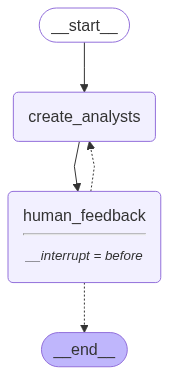

In [13]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topics:
{topic}
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts:
{human_analyst_feedback}
3. Determine the most iny=terestion themes based upon documents and / or feedback above.
4. Pick the top {max_analysts} themes.
5. Assign one analyst to each theme."""

def create_analysts(state: GenerateAnalystsState):
    """Create analysts"""
    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback','')

    structured_llm = llm.with_structured_output(Perspectives)

    system_message = analyst_instructions.format(topic=topic, human_analyst_feedback=human_analyst_feedback, max_analysts=max_analysts)

    analysts = structured_llm.invoke([SystemMessage(content=system_message)] + [HumanMessage(content="Generate the set of analysts.")])

    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """Return the next node to execute """

    human_analyst_feedback=state.get("human_analyst_feedback",None)
    if human_analyst_feedback:
        return "create_analysts"
    
    return END

builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue,["create_analysts", END])

memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [16]:
max_analysts = 3
topic = ''' The benefits of adopting LangGraph as an agent framework'''
thread = {"configurable": {"thread_id": "1"}}

for event in graph.stream({"topic":topic, "max_analysts":max_analysts,}, thread, stream_mode="values"):
    analysts = event.get('analysts','')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-"*50)


Name: Dr. Anya Sharma
Affiliation: AI Research Institute
Role: AI Research Scientist
Description: Focuses on the technical advantages of LangGraph, such as its ability to manage complex conversational flows and improve agent reliability. They are motivated by the desire to advance the state of AI research and see LangGraph as a promising tool.
--------------------------------------------------
Name: Kenji Tanaka
Affiliation: Large Language Model (LLM) Development Company
Role: Lead AI Engineer
Description: Concerned with the practical applications of LangGraph for building more robust and scalable LLM-powered agents. Their motive is to improve the efficiency and effectiveness of their agents for commercial use cases.
--------------------------------------------------
Name: Dr. Maria Rodriguez
Affiliation: AI Ethics and Society Institute
Role: AI Ethics Researcher
Description: Interested in the ethical implications of using LangGraph, particularly its potential to create more complex an

In [17]:
state = graph.get_state(thread)
state.next

('human_feedback',)

In [18]:
graph.update_state(thread,{"human_analyst_feedback":
                           "Add in someome from a startup to add an entrepreneur perspective."}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f05e3de-1e45-61ed-8007-7bf96c227eff'}}

In [19]:
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts','')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-"*50)


Name: Dr. Anya Sharma
Affiliation: AI Research Lab
Role: AI Research Scientist
Description: Focuses on the technical advantages of LangGraph, such as its ability to create more robust and reliable agent workflows compared to traditional methods. They highlight the benefits of state management and the ability to handle complex, multi-agent interactions effectively.
--------------------------------------------------
Name: Mr. Ben Carter
Affiliation: Enterprise Solutions Firm
Role: Lead Solutions Architect
Description: Concerned with the practical applications and ROI of LangGraph. They focus on how it can be used to streamline business processes, automate complex tasks, and improve decision-making. They emphasize the importance of scalability, security, and integration with existing enterprise systems.
--------------------------------------------------
Name: Professor Emily Chen
Affiliation: AI Ethics Institute
Role: AI Ethics Researcher
Description: Prioritizes the ethical implications 